<a href="https://colab.research.google.com/github/Kalyandask/FMML-Projects-and-labs/blob/main/AIML_project_module5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NIFTY 50 Trend Analysis & Prediction

Step 1: Install & Import Libraries

In [2]:
!pip install yfinance --quiet

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

# Style settings
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 6

Step 2: Load Live Data

Instead of reading a CSV, we download the last 2 years of data for NIFTY 50 (The Indian Benchmark Index).

In [3]:
stock_symbol = '^NSEI'
data = yf.download(stock_symbol, period='2y', interval='1d')

# Reset index to make Date a column
data = data.reset_index()

# Prepare 'Days Since' for regression (Models can't read Date objects directly)
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['Days Since'] = (data['Date'] - start_date).dt.days

# We will predict the 'Close' price
df = data[['Date', 'Days Since', 'Close']].copy()

print(f"Data fetched for {stock_symbol}")
print(df.tail())

/tmp/ipython-input-3300455488.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, period='2y', interval='1d')
[*********************100%***********************]  1 of 1 completed

Data fetched for ^NSEI
Price        Date Days Since         Close
Ticker                               ^NSEI
488    2025-11-12        723  25875.800781
489    2025-11-13        724  25879.150391
490    2025-11-14        725  25910.050781
491    2025-11-17        728  26013.449219
492    2025-11-18        729  25910.050781


Step 3: Visualize the Current Trend

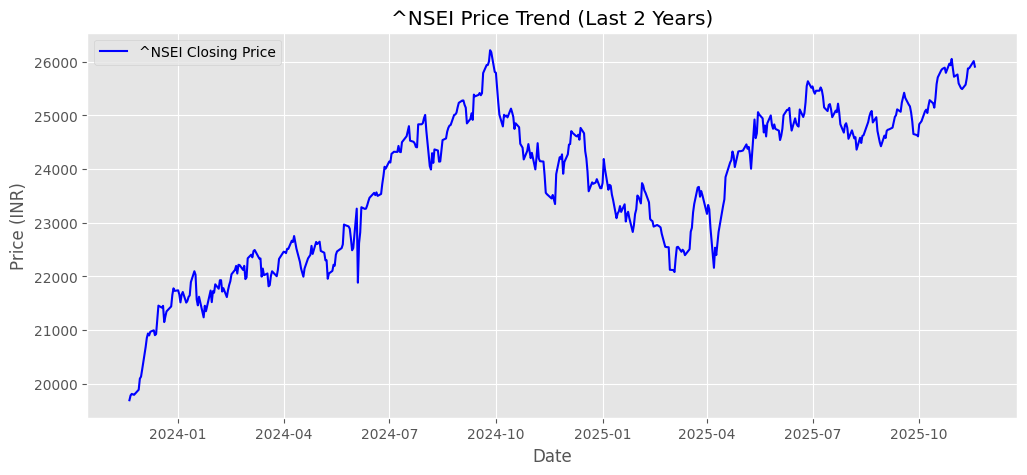

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label=f'{stock_symbol} Closing Price', color='blue')
plt.title(f"{stock_symbol} Price Trend (Last 2 Years)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()

Step 4: Preprocessing & Split

In [5]:
# X is our feature (Time), y is our target (Price)
X = np.array(df['Days Since']).reshape(-1, 1)
y = np.array(df['Close'])

# Split: 85% Train, 15% Test
# We do NOT shuffle because this is time-series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

print(f"Training days: {len(X_train)}")
print(f"Testing days: {len(X_test)}")

Training days: 419
Testing days: 74


Step 5: Linear & Polynomial Regression

In [6]:
# --- 1. Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)

# --- 2. Polynomial Regression (Degree 4) ---
# We use Degree 4 because stock trends are complex waves
poly = PolynomialFeatures(degree=4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)

# Fit the model
poly_model = LinearRegression()
poly_model.fit(poly_X_train, y_train)
poly_pred = poly_model.predict(poly_X_test)

# Calculate Error Metrics
mae_lin = mean_absolute_error(y_test, lin_pred)
mae_poly = mean_absolute_error(y_test, poly_pred)

print(f"Linear Regression MAE: {mae_lin:.2f}")
print(f"Polynomial Regression MAE: {mae_poly:.2f}")

Linear Regression MAE: 374.70
Polynomial Regression MAE: 6391.81


Step 6: Bayesian Ridge Regression (Regularization)

In [7]:
# Setup the Hyperparameter Grid (Same as your previous project)
bayesian_grid = {
    'tol': [1e-4, 1e-3],
    'alpha_1': [1e-6, 1e-5],
    'alpha_2': [1e-6, 1e-5],
    'lambda_1': [1e-6, 1e-5],
    'lambda_2': [1e-6, 1e-5]
}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, n_iter=20)

# Fit on Polynomial Features (Ridge Polynomial Regression)
bayesian_search.fit(poly_X_train, y_train)
best_model = bayesian_search.best_estimator_

# Predict
ridge_pred = best_model.predict(poly_X_test)
mae_ridge = mean_absolute_error(y_test, ridge_pred)

print(f"Ridge Polynomial MAE: {mae_ridge:.2f}")

Ridge Polynomial MAE: 6157.06


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Step 7: Final Visualization & Future Forecasting

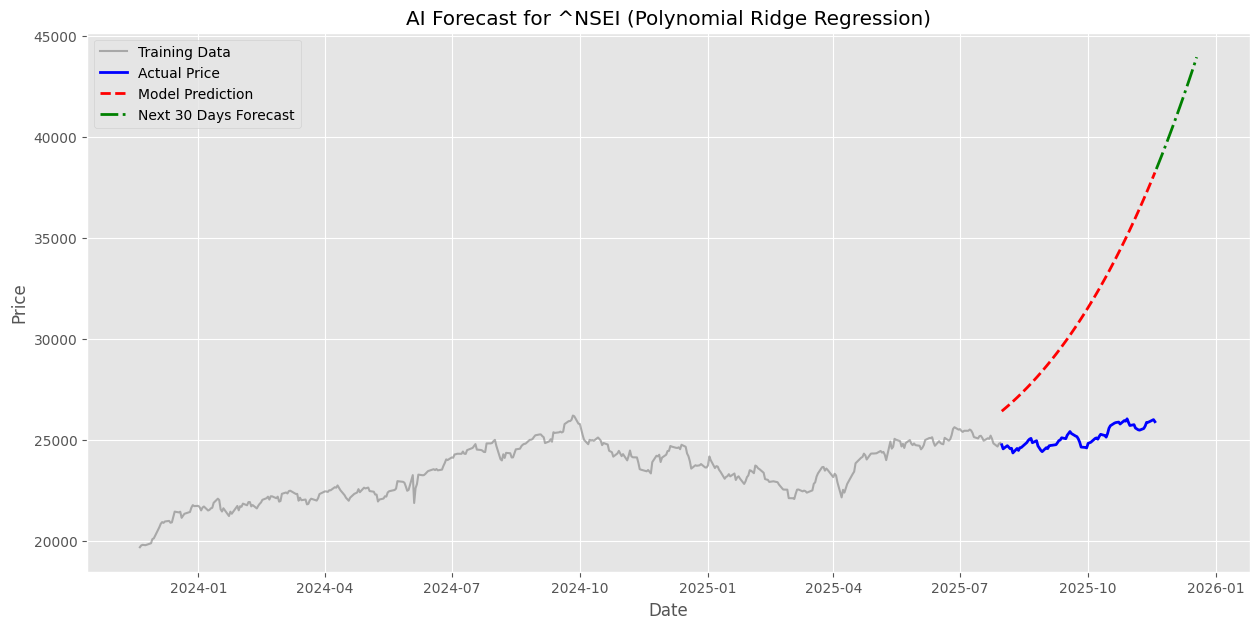

In [8]:
# Generate future dates (Next 30 days)
last_day = df['Days Since'].iloc[-1]
future_days = np.array([last_day + i for i in range(1, 31)]).reshape(-1, 1)
future_dates = [df['Date'].iloc[-1] + timedelta(days=i) for i in range(1, 31)]

# Transform future days for polynomial model
poly_future = poly.fit_transform(future_days)
future_pred = best_model.predict(poly_future)

# --- PLOTTING ---
plt.figure(figsize=(15, 7))

# 1. Plot Training Data
plt.plot(df['Date'].iloc[:len(X_train)], y_train, label='Training Data', color='gray', alpha=0.6)

# 2. Plot Actual Test Data (The "Truth")
test_dates = df['Date'].iloc[len(X_train):]
plt.plot(test_dates, y_test, label='Actual Price', color='blue', linewidth=2)

# 3. Plot Ridge Prediction
plt.plot(test_dates, ridge_pred, label='Model Prediction', color='red', linestyle='--', linewidth=2)

# 4. Plot Future Forecast
plt.plot(future_dates, future_pred, label='Next 30 Days Forecast', color='green', linestyle='-.', linewidth=2)

plt.title(f"AI Forecast for {stock_symbol} (Polynomial Ridge Regression)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()